### **Identifying Accident Prone Areas In The United Kingdom**

Over 9 years (2005-2014), the British government collected data on traffic accidents, resulting in a database of over 1.6 million entries. This project uses K-means and MiniBatchKMeans clustering algorithms to identify high accident-density areas in the UK, comparing their effectiveness to determine if a quicker, low-cost algorithm can deliver results as effectively as a computationally heavier one. [UK traffic accidents dataset](https://www.kaggle.com/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales?resource=download). Sai Vamsi Krishna Yerramsetti: [Github](https://github.com/VamsiYerramsetti). *Note:* In order to limit the report to 2 pages I commented in-line instead of docstrings.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree

#### Data ingestion, pre-processing and wrangling
The functions process accident data by rounding coordinates to two decimals to avoid duplicates, merging with traffic flow data by matching coordinates, and removing missing values. Coordinates are standardized for consistency, ensuring the data is clean, normalized, and ready for clustering and analysis.

In [7]:
def load_and_process_input_data(years):
    accident_data = pd.concat([pd.read_csv(f'accidents_{year}.csv', low_memory=False) for year in years])
    locations = accident_data[['Longitude', 'Latitude']].dropna().round(2) # Filter and round coordinates
    locations = locations.groupby(['Longitude', 'Latitude']).size().reset_index(name='counts')
    aadf = pd.read_csv('ukTrafficAADF.csv')[['Lon', 'Lat', 'AllMotorVehicles']].dropna()#Preprocess traffic-flow
    aadf.columns = ['longitude', 'latitude', 'all_motor_vehicles']
    aadf = aadf.round(2).groupby(['longitude', 'latitude']).mean().reset_index() # Round traffic-flow data
    return locations, aadf

def calculate_weights_and_distances(locations, aadf):
    aadf_coords = aadf[['longitude', 'latitude']].values  # Extract coordinates
    aadf_weights = aadf['all_motor_vehicles'].values  # Extract weights

    weights = np.zeros(len(locations))  # Initialize weights array
    mindists = np.full(len(locations), np.inf)  # Initialize mindists array with infinity

    tree = cKDTree(aadf_coords) # Used KDTree for faster nearest neighbor search to improve performance
    #Query KDTree for nearest-neighbors
    dists, indices = tree.query(locations[['Longitude', 'Latitude']].values, k=1)
    weights = aadf_weights[indices] # Update weights and mindists based on nearest neighbors
    mindists = dists

    locations['weight'] = weights  # Add weights to locations
    return weights, mindists  # Return weights and mindists

def standardize_data(locations):  # Standardizes the 'Longitude' and 'Latitude' columns in the locations df
    scaler = StandardScaler()
    locations[['Longitude', 'Latitude']] = scaler.fit_transform(locations[['Longitude', 'Latitude']])
    return locations

#### Clustering via and Kmeans and MiniBatch Kmeans
The below functions cluster accident locations using K-means and MiniBatchKMeans, considering accident severity and frequency. K-means minimizes variance to form K-clusters, while MiniBatchKMeans processes data in small batches for efficiency. A high K-value creates many small clusters, identifying high-density, accident-prone areas and marking others as noise.

In [8]:
def perform_kmeans(locations, n_clusters=100):  # Perform KMeans clustering
    km = KMeans(n_clusters=n_clusters)
    km.fit(locations[['Longitude', 'Latitude']], sample_weight=locations['counts'] / locations['weight'])
    return km

def perform_minibatch_kmeans(locations, n_clusters=100):  # Perform MiniBatchKMeans clustering
    mbkm = MiniBatchKMeans(n_clusters=n_clusters)
    mbkm.fit(locations[['Longitude', 'Latitude']], sample_weight=locations['counts'] / locations['weight'])
    return mbkm

#### Data visualisation, Plotting and Results


In [9]:
def plot_clustering_results(locations, km, mbkm, top_n=5):# Plots and highlight clustering results
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # Create subplots

    def plot_clusters(ax, title, labels):  #  Function to plot clusters
        for i in sorted(set(labels)):  # Iterate over each cluster label
            points = locations[labels == i]  # Get points belonging to the current cluster
            ax.scatter(points['Longitude'], points['Latitude'], s=points['counts'] / points['weight']* 10)
        ax.set(xlabel='longitude', ylabel='latitude', title=title)
        ax.xaxis.label.set_size(16), ax.yaxis.label.set_size(16), ax.title.set_size(18)

        top_clusters = get_top_clusters(labels)  # Get top clusters based on density
        for i in top_clusters:  # Highlight top clusters with red edges
            points = locations[labels == i]
            cluster_sizes = points['counts'] / points['weight'] * 10
            ax.scatter(points['Longitude'], points['Latitude'], s=cluster_sizes, edgecolors='r', linewidths=2)

    def get_top_clusters(labels):  # Function to get top clusters based on density
        densities = [(sum(points['counts'] / points['weight']) / len(points), x) for x in set(labels)
          if (points := locations[labels == x]).size > 0]
        return [x for _, x in sorted(densities, reverse=True)[:top_n]]

    plot_clusters(axs[0], 'KMeans clustering for K=100', km.labels_) # Plot KMeans clustering
    plot_clusters(axs[1], 'MiniBatchKMeans clustering for K=100', mbkm.labels_)  # Plot MiniBatchKMeans

    top_clusters_km = get_top_clusters(km.labels_)  # Get top clusters from KMeans results
    top_clusters_mbkm = get_top_clusters(mbkm.labels_)  # Get top clusters from MiniBatchKMeans results

    axs[2].scatter(locations['Longitude'], locations['Latitude'], s=locations['counts']/locations['weight']*10)

    for i in top_clusters_km + top_clusters_mbkm: #Highlight top clusters from both methods in combined plot
        points = locations[(km.labels_ == i) | (mbkm.labels_ == i)]
        axs[2].scatter(points['Longitude'], points['Latitude'], s=points['counts'] / points['weight'] * 10)
    axs[2].set(xlabel='Longitude',ylabel='Latitude',title='Top density based clusters found by both methods')
    axs[2].xaxis.label.set_size(16), axs[2].yaxis.label.set_size(16), axs[2].title.set_size(18)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display plots

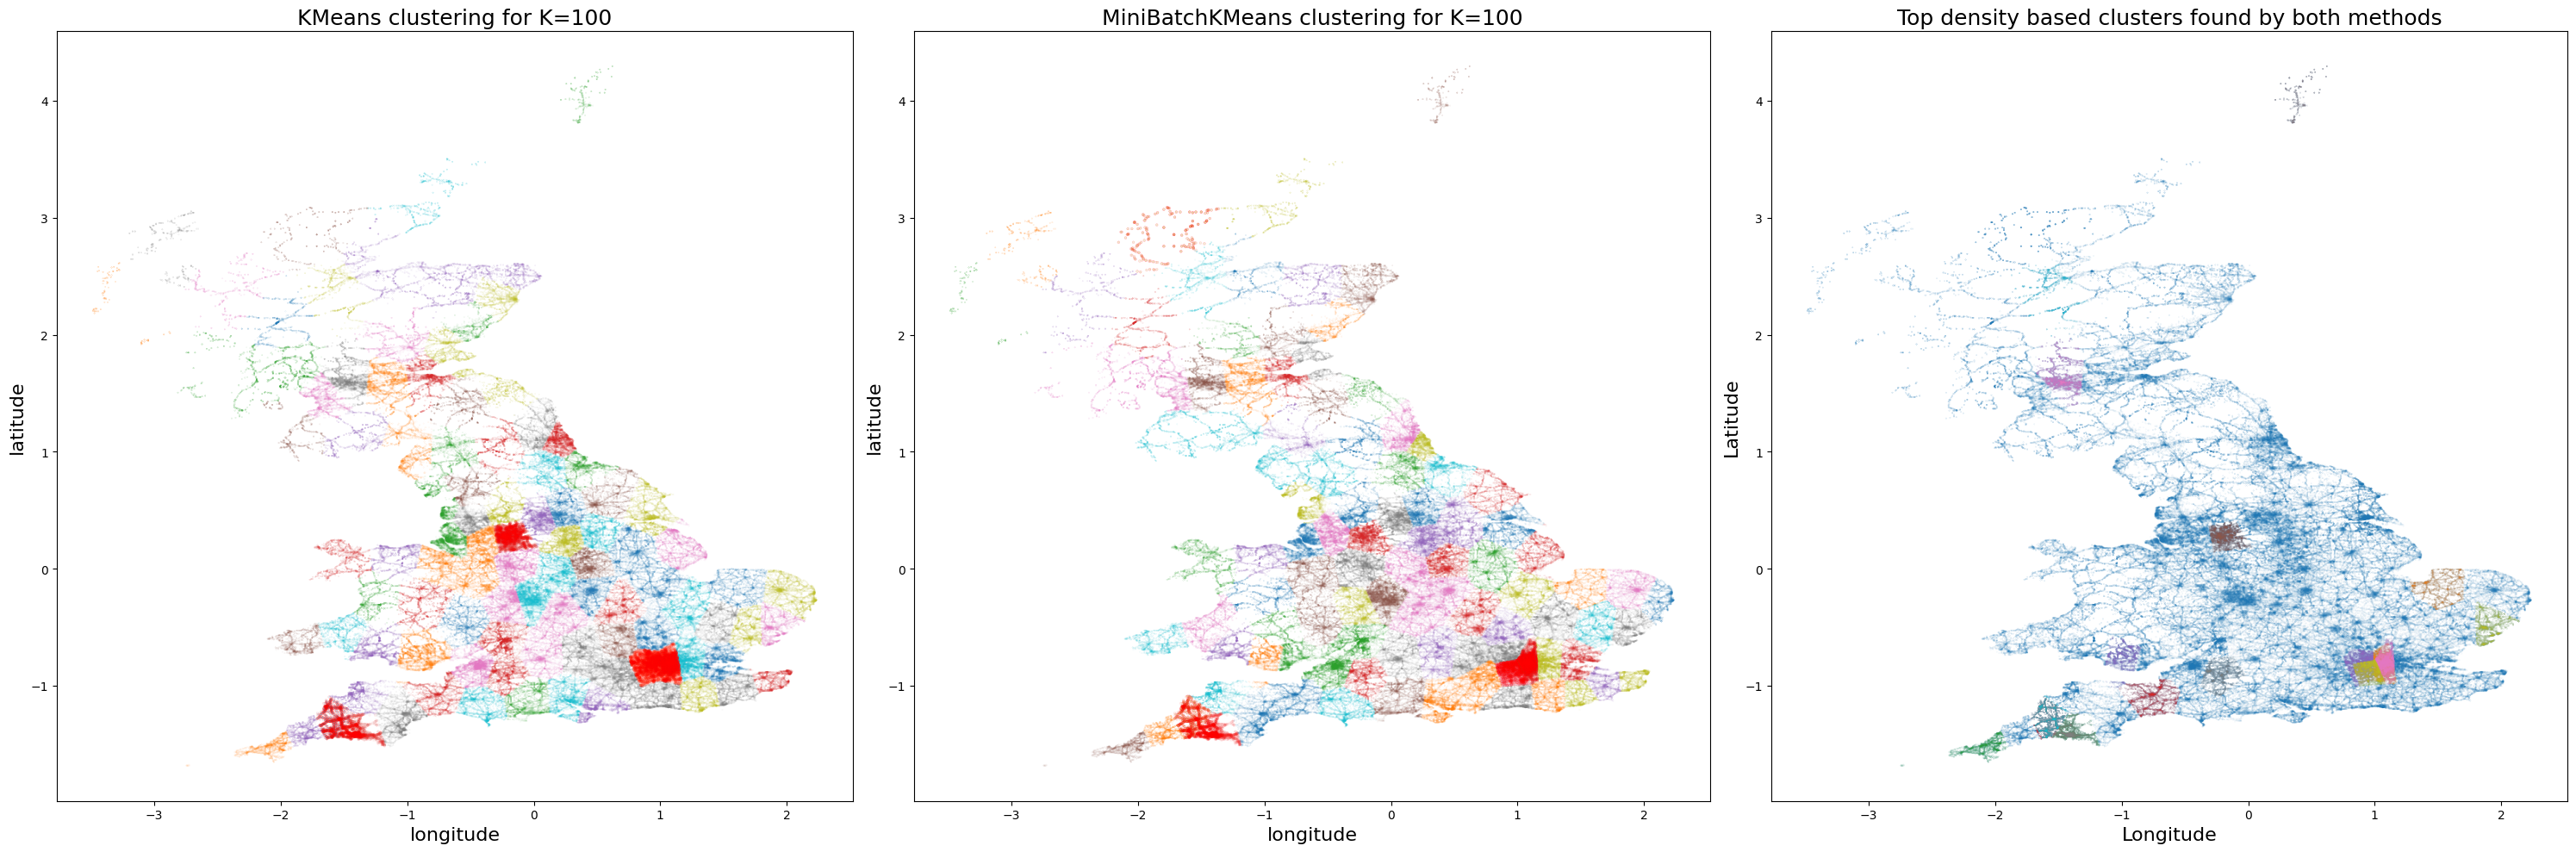

In [10]:
year_ranges = ['2005_to_2007', '2009_to_2011', '2012_to_2014']
locations, aadf = load_and_process_input_data(year_ranges)  #Pre-processing steps
weights, mindists = calculate_weights_and_distances(locations, aadf)
locations = standardize_data(locations) # Standardize coordinates
km = perform_kmeans(locations)  # Perform KMeans clustering
mbkm = perform_minibatch_kmeans(locations)  # Perform MiniBatchKMeans clustering
plot_clustering_results(locations, km, mbkm)  # Plot clustering results

####Results and Inference

1. **Accident-Prone Zones:** High-density clusters in both methods indicate accident-prone zones, primarily around **London, the Midlands, Manchester, Liverpool, and southern Scotland.** These areas align with higher population density and transportation activity, highlighting their vulnerability to accidents.

2. **KMeans vs. MiniBatchKMeans:** KMeans produces **stable results** with **smoother cluster boundaries**, particularly in rural regions. MiniBatchKMeans is computationally faster and better at identifying **compact accident-prone zones** in dense urban areas, making it ideal for large-scale datasets. Shared clusters in the third plot validate the reliability of both methods in identifying critical zones.

3. **MiniBatchKMeans** performs better for this dataset, especially for dense regions, offering comparable accuracy to KMeans with faster computation. Its efficiency makes it suitable for real-time and large-scale geographic analyses.